In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
)
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import norm

# Configurações para os gráficos
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 7)

## Definindo as covariáveis

Iremos utilizar a covariável básica de trend, em conjunto com a indicadora mensal, e por fim, adicionar os lags de 1, 4 e 12 semanas, além disso, também iremos incluir as médias móveis e médias móveis exponencias de 4 e 12 semanas, e por fim, a volatilidade de 4 e 12 semanas.

Visto que a série temporal não apresenta sazonalidade anual, não iremos adicionar variáveis muito distantes no tempo.

In [2]:
# Carregando os dados originais
data = pd.read_csv("../data.csv")
data["week"] = pd.to_datetime(data["week"])
data_series = data.set_index("week")['volume']

# --- Definição de Atributos ---
df = pd.DataFrame({'volume': data_series})
df['trend'] = range(len(df))

# Dummies mensais
df['month'] = df.index.month
df = pd.get_dummies(df, columns=['month'], drop_first=True, prefix='mes')
dummy_cols = [col for col in df.columns if 'mes_' in col]
df[dummy_cols] = df[dummy_cols].astype(int)

# Lags
df['lag_1'] = df['volume'].shift(1)
df['lag_4'] = df['volume'].shift(4)
df['lag_12'] = df['volume'].shift(12)

# Médias Móveis (Simples e Exponencial)
df['volume_sma_4'] = df['volume'].rolling(window=4).mean().shift(1)
df['volume_sma_12'] = df['volume'].rolling(window=12).mean().shift(1)
df['volume_ema_4'] = df['volume'].ewm(span=4, adjust=False).mean().shift(1)
df['volume_ema_12'] = df['volume'].ewm(span=12, adjust=False).mean().shift(1)

# Desvio Padrão Móvel
df['volume_std_4'] = df['volume'].rolling(window=4).std().shift(1)
df['volume_std_12'] = df['volume'].rolling(window=12).std().shift(1)

df.dropna(inplace=True)

X = df.drop('volume', axis=1)
y = df['volume']

Definindo o conjunto de treinamento e teste:

In [3]:
# Divisão cronológica dos dados
train_size_full = len(data_series)
train_size_adjusted = int(train_size_full * 0.8) - 12

X_train, X_test = X.iloc[:train_size_adjusted], X.iloc[train_size_adjusted:]
y_train, y_test = y.iloc[:train_size_adjusted], y.iloc[train_size_adjusted:]

train_volume = data_series.iloc[: int(train_size_full * 0.8)]
test_volume = data_series.iloc[int(train_size_full * 0.8) :]

## Gerando as predições dos modelos

Considerando as covariáveis como grupos, para ver o desempenho de cada grupo de variáveis.

In [4]:
predictions = {}
models = {}

months_cols = [col for col in X.columns if 'mes_' in col]
lag_cols = ['lag_1', 'lag_4', 'lag_12']
ma_cols = ['volume_sma_4', 'volume_sma_12', 'volume_ema_4', 'volume_ema_12']
std_cols = ['volume_std_4', 'volume_std_12']

models_cols = {
    'Tendência': ['trend'],
    'Meses': months_cols,
    'Lags': lag_cols,
    'Médias Móveis': ma_cols,
    'Desvio Padrão Móvel': std_cols,
}

for model_name, cols in models_cols.items():
    X_train_model = sm.add_constant(X_train[cols])
    X_test_model = sm.add_constant(X_test[cols])

    model = sm.OLS(y_train, X_train_model).fit()
    models[model_name] = model

    y_pred = model.predict(X_test_model)
    predictions[model_name] = y_pred

In [5]:
# Função para o Winkler Score
def winkler_score(y_true, lower, upper, alpha):
    score = np.where(
        y_true < lower,
        (upper - lower) + (2 / alpha) * (lower - y_true),
        np.where(
            y_true > upper,
            (upper - lower) + (2 / alpha) * (y_true - upper),
            (upper - lower),
        ),
    )
    return np.mean(score)


# Função para o Erro de Quantil
def quantile_score(y_true, quantile_forecast, p):
    error = y_true - quantile_forecast
    return np.mean(np.where(error >= 0, p * error, (p - 1) * error))


# Função para o CRPS de uma distribuição Normal
def crps_gaussian(y_true, mu, sigma):
    z = (y_true - mu) / sigma
    crps = sigma * (
        z * (2 * norm.cdf(z) - 1) + 2 * norm.pdf(z) - 1 / np.sqrt(np.pi)
    )
    return np.mean(crps)

## Analisando as métricas das predições dos grupos

In [6]:
intervals = {}
residuals_std = {}


def update_and_get_metrics(
    models, predictions, results_list, train_volume, test_volume, alpha=0.05
):
    processed_models = [res['Modelo'] for res in results_list]

    new_model_names = [
        name for name in models.keys() if name not in processed_models
    ]

    if not new_model_names:
        return pd.DataFrame(results_list).set_index('Modelo')

    for name in new_model_names:
        residuals_std[name] = models[name].resid.std()

    for name in new_model_names:
        forecast = predictions[name]
        sigma = residuals_std[name]
        z_score = norm.ppf(1 - alpha / 2)
        intervals[name] = {
            'lower': forecast - z_score * sigma,
            'upper': forecast + z_score * sigma,
        }

    # --- Cálculo das Métricas ---
    m = 12  # Sazonalidade para o scale do MASE
    scale = np.mean(np.abs(train_volume.diff(m).dropna()))
    quantiles_to_check = [0.1, 0.25, 0.5, 0.75, 0.9]

    for name in new_model_names:
        forecast = predictions[name]
        current_test_volume = test_volume[forecast.index]
        interval = intervals[name]
        sigma = residuals_std[name]

        # Métricas de erro pontual
        mae = mean_absolute_error(current_test_volume, forecast)
        rmse = np.sqrt(mean_squared_error(current_test_volume, forecast))
        mape = mean_absolute_percentage_error(current_test_volume, forecast)
        mase = mae / scale

        # Métricas probabilísticas
        winkler = winkler_score(
            current_test_volume, interval['lower'], interval['upper'], alpha
        )
        sigma_h = pd.Series(sigma, index=current_test_volume.index)
        crps = crps_gaussian(current_test_volume, forecast, sigma_h)

        # Métrica de quantil
        avg_quantile_loss = []
        for p in quantiles_to_check:
            quantile_forecast = norm.ppf(p, loc=forecast, scale=sigma_h)
            avg_quantile_loss.append(
                quantile_score(current_test_volume, quantile_forecast, p)
            )

        # Adiciona os resultados à lista
        results_list.append(
            {
                'Modelo': name,
                'MAE': mae,
                'RMSE': rmse,
                'MAPE (%)': mape * 100,
                'MASE': mase,
                'Winkler Score': winkler,
                'Avg Quantile Score': np.mean(avg_quantile_loss),
                'CRPS': crps,
            }
        )

    return pd.DataFrame(results_list).set_index('Modelo')


results_list = []

results_df = update_and_get_metrics(
    models, predictions, results_list, train_volume, test_volume
)

print("\n--- Tabela Comparativa de Métricas (Grupos de Covariáveis) ---")
results_df.round(4).sort_values(by='RMSE')


--- Tabela Comparativa de Métricas (Grupos de Covariáveis) ---


,MAE,RMSE,MAPE (%),MASE,Winkler Score,Avg Quantile Score,CRPS
Modelo,,,,,,,
Médias Móveis,1.3680,1.7275,13.1918,1.0057,19.9436,0.5458,1.0940
Lags,1.3731,1.7571,12.9775,1.0095,22.2627,0.5457,1.0980
Desvio Padrão Móvel,3.7363,4.4954,33.7427,2.7467,78.0712,1.5835,3.1663
Tendência,3.8318,4.5048,33.2286,2.8169,53.7312,1.5146,3.0359
Meses,7.2768,7.7198,68.1374,5.3495,120.3251,3.0051,5.9801


Pelos resultados podemos observar que o modelo de médias móveis apresentou o melhor desempenho, seguido do modelo com lags, que performaram bem melhores do que o modelo básico com trend e volatiliade, e o modelo de indicadoras mensais foi o pior de todos.

## Analisando os parâmetros dos melhores modelos

In [7]:
models["Médias Móveis"].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 volume   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     328.9
Date:                Wed, 01 Oct 2025   Prob (F-statistic):           1.07e-57
Time:                        18:45:22   Log-Likelihood:                -107.90
No. Observations:                 108   AIC:                             225.8
Df Residuals:                     103   BIC:                             239.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1341      0.102      1.316      0.191      -0.068       0.336
volume_sma_4     -1.3314      0.364     -3.660      0.000      -2.053      -0.610
volume_sma_12    -0.7518      0.430     -1.747      0.084      -1.605       0.102
volume_ema_4      2.6379      0.386      6.838      0.000       1.873       3.403
volume_ema_12     0.4198      0.540      0.777      0.439      -0.651       1.491
==============================================================================
Omnibus:                        7.729   Durbin-Watson:                   1.579
Prob(Omnibus):                  0.021   Jarque-Bera (JB):               14.378
Skew:                          -0.130   Prob(JB):                     0.000755
Kurtosis:                       4.769   Cond. No.                         75.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
models["Lags"].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 volume   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     510.7
Date:                Wed, 01 Oct 2025   Prob (F-statistic):           4.63e-62
Time:                        18:45:22   Log-Likelihood:                -100.72
No. Observations:                 108   AIC:                             209.4
Df Residuals:                     104   BIC:                             220.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1568      0.091      1.717      0.089      -0.024       0.338
lag_1          0.8982      0.057     15.719      0.000       0.785       1.011
lag_4          0.1660      0.072      2.321      0.022       0.024       0.308
lag_12        -0.1091      0.044     -2.505      0.014      -0.195      -0.023
==============================================================================
Omnibus:                        5.943   Durbin-Watson:                   1.794
Prob(Omnibus):                  0.051   Jarque-Bera (JB):                9.322
Skew:                          -0.079   Prob(JB):                      0.00946
Kurtosis:                       4.431   Cond. No.                         9.47
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Vemos um problema no modelo de médias móveis, onde o parâmetro volume_ema_12 tem um p-valor alto, e seu intervalo de confiança inclui o zero, indicando que esse parâmetro não é estatisticamente significativo.

Levando isso em consideração, criaremos novos modelos removendo esse parâmetro e juntando mais grupos de variáveis para analisar o desempenho.

In [9]:
ma_cols.remove("volume_ema_12")

models_combined_cols = {
    "Médias Móveis (Simplificada)": ma_cols,
    "Lags + Médias Móveis": lag_cols + ma_cols,
    "Lags + Médias Móveis + Tendência": lag_cols + ma_cols + ['trend'],
    "Lags + Médias Móveis + Desvio Padrão": lag_cols + ma_cols + std_cols,
}

for model_name, cols in models_combined_cols.items():
    X_train_model = sm.add_constant(X_train[cols])
    X_test_model = sm.add_constant(X_test[cols])

    model = sm.OLS(y_train, X_train_model).fit()
    models[model_name] = model

    y_pred = model.predict(X_test_model)
    predictions[model_name] = y_pred

In [10]:
results_df = update_and_get_metrics(models, predictions, results_list, train_volume, test_volume)

print("\n--- Tabela Comparativa de Métricas Atualizada (Modelos Combinados) ---")
results_df.round(4).sort_values(by='RMSE')


--- Tabela Comparativa de Métricas Atualizada (Modelos Combinados) ---


,MAE,RMSE,MAPE (%),MASE,Winkler Score,Avg Quantile Score,CRPS
Modelo,,,,,,,
Médias Móveis,1.3680,1.7275,13.1918,1.0057,19.9436,0.5458,1.0940
Médias Móveis (Simplificada),1.3870,1.7325,13.4134,1.0197,19.7772,0.5536,1.1106
Lags,1.3731,1.7571,12.9775,1.0095,22.2627,0.5457,1.0980
Lags + Médias Móveis,1.4475,1.8576,13.8147,1.0642,25.0619,0.5993,1.1969
Lags + Médias Móveis + Tendência,1.4439,1.8770,13.6818,1.0615,25.7232,0.5964,1.1915
Lags + Médias Móveis + Desvio Padrão,1.5293,2.0021,14.4195,1.1243,28.6114,0.6384,1.2755
Desvio Padrão Móvel,3.7363,4.4954,33.7427,2.7467,78.0712,1.5835,3.1663
Tendência,3.8318,4.5048,33.2286,2.8169,53.7312,1.5146,3.0359
Meses,7.2768,7.7198,68.1374,5.3495,120.3251,3.0051,5.9801


Analisando os grupos de modelos é visível que, nenhum grupo performou melhor do que o modelo de médias móveis, considerando o modelo mais simples, das médias.

In [11]:
models["Médias Móveis (Simplificada)"].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 volume   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     440.0
Date:                Wed, 01 Oct 2025   Prob (F-statistic):           6.31e-59
Time:                        18:45:22   Log-Likelihood:                -108.22
No. Observations:                 108   AIC:                             224.4
Df Residuals:                     104   BIC:                             235.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1576      0.097      1.622      0.108      -0.035       0.350
volume_sma_4     -1.3445      0.363     -3.707      0.000      -2.064      -0.625
volume_sma_12    -0.4258      0.097     -4.399      0.000      -0.618      -0.234
volume_ema_4      2.7309      0.366      7.461      0.000       2.005       3.457
==============================================================================
Omnibus:                        7.618   Durbin-Watson:                   1.560
Prob(Omnibus):                  0.022   Jarque-Bera (JB):               13.943
Skew:                          -0.134   Prob(JB):                     0.000938
Kurtosis:                       4.740   Cond. No.                         47.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Temos como resultado um modelo quase infimamente pior, mas com parâmetros significativos.

## Visualizando resultados

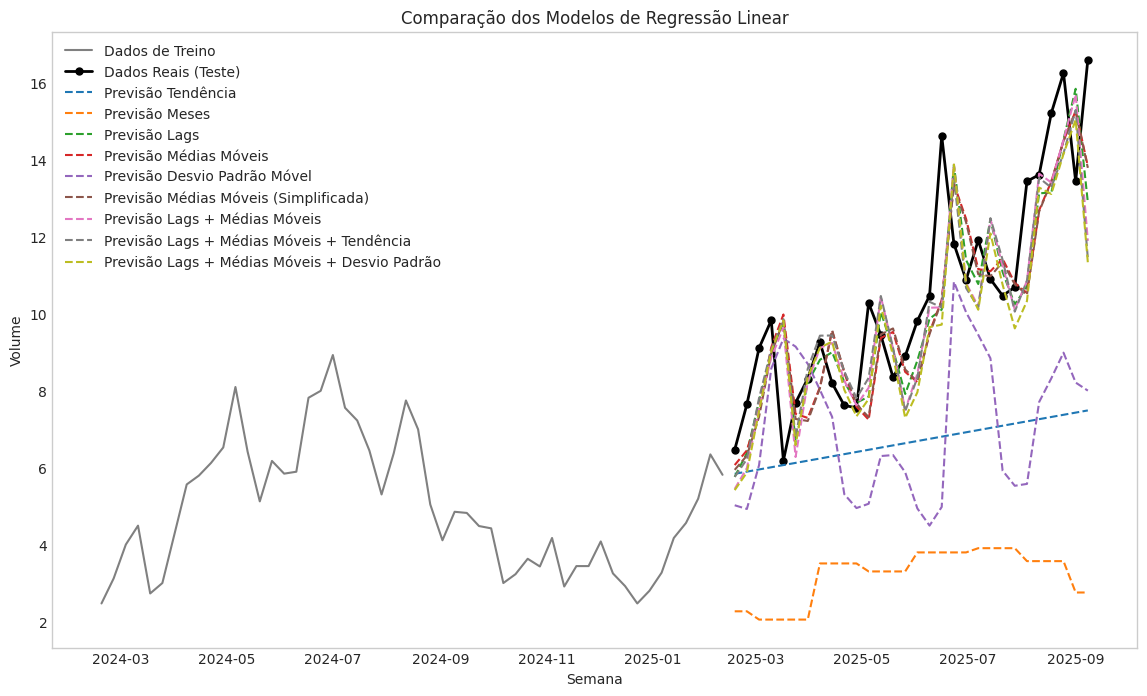

In [12]:
# Visualização e Avaliação Final

plt.figure(figsize=(14, 8))
plt.plot(y_train.iloc[-52:], label='Dados de Treino', color='gray')

plt.plot(
    y_test,
    label='Dados Reais (Teste)',
    color='black',
    linewidth=2,
    marker='o',
    markersize=5,
)

for name, forecast in predictions.items():
    plt.plot(forecast, label=f'Previsão {name}', linestyle='--')

plt.title('Comparação dos Modelos de Regressão Linear')
plt.xlabel('Semana')
plt.ylabel('Volume')
plt.legend(loc='upper left')
plt.grid(False)

plt.show()

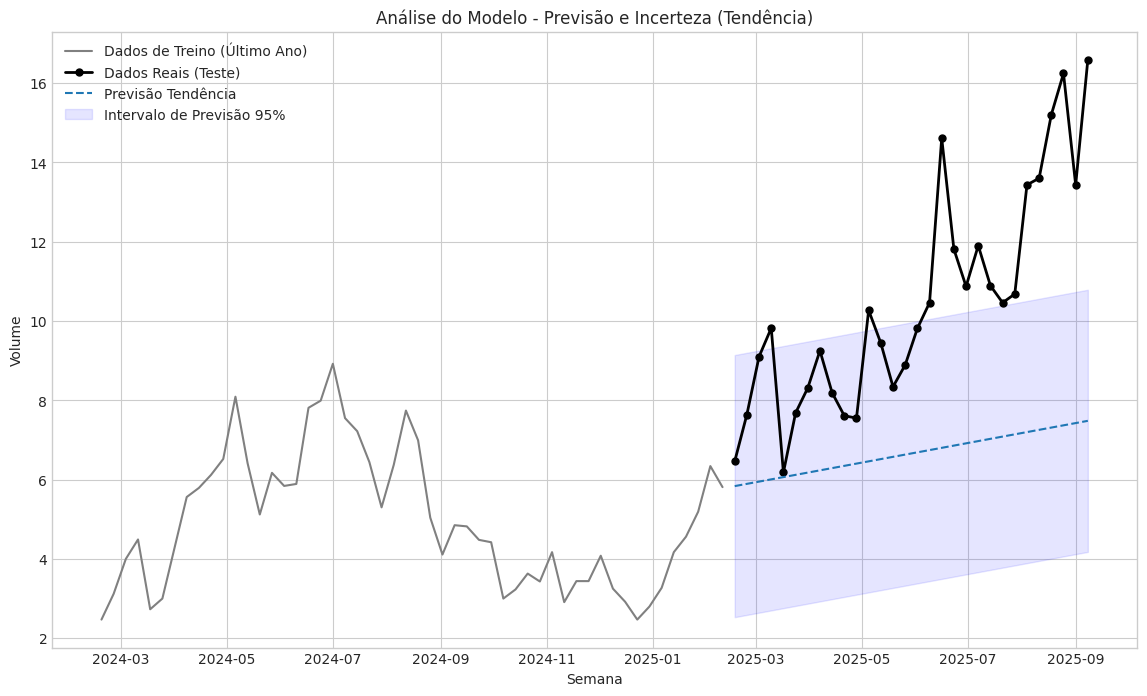

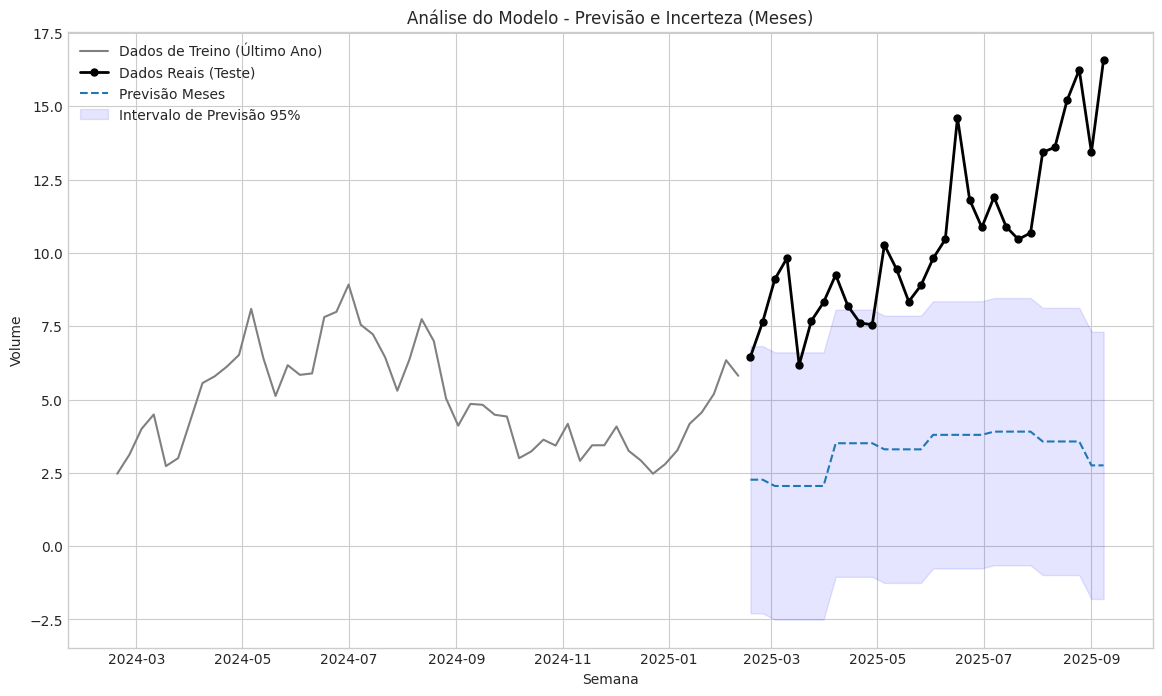

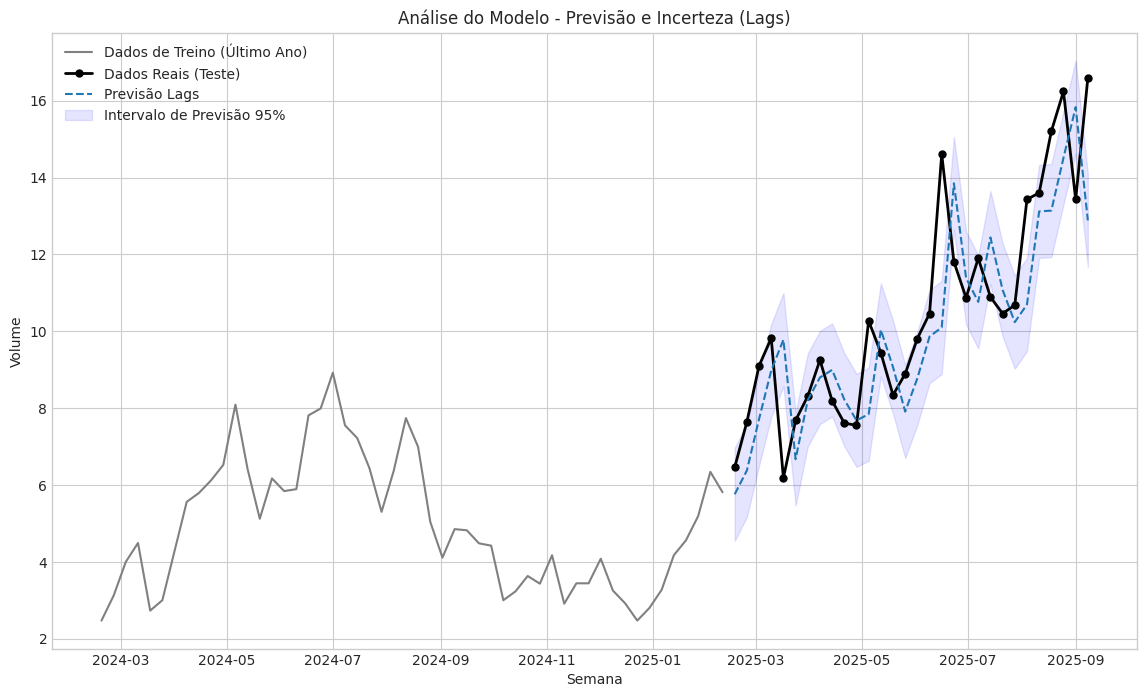

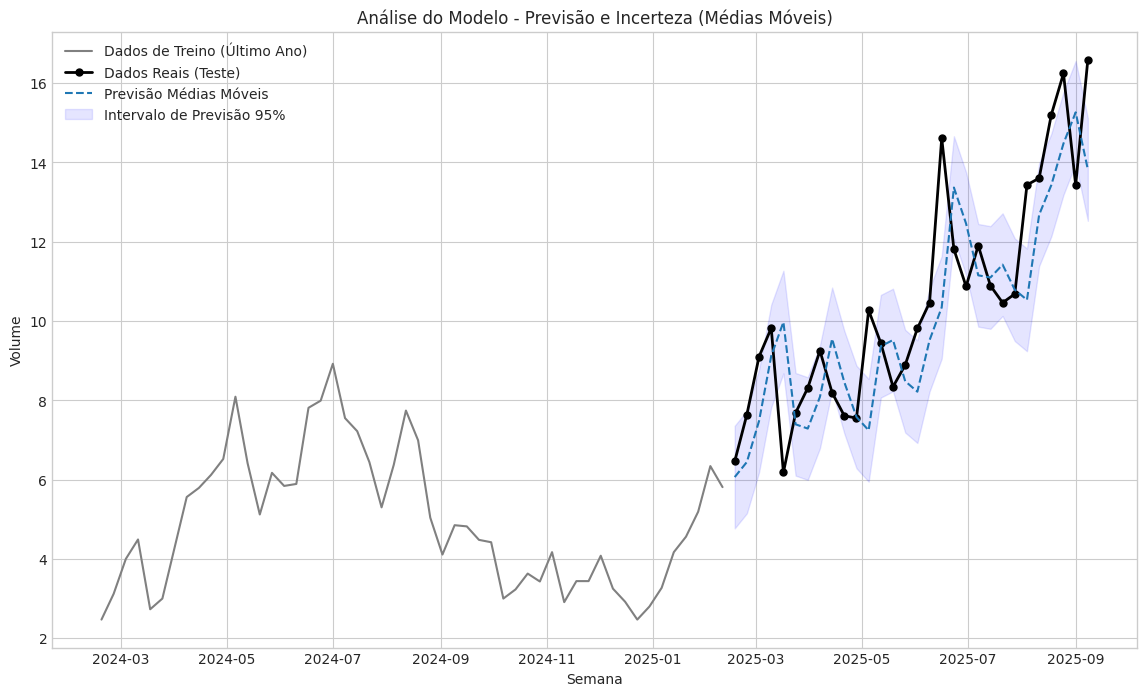

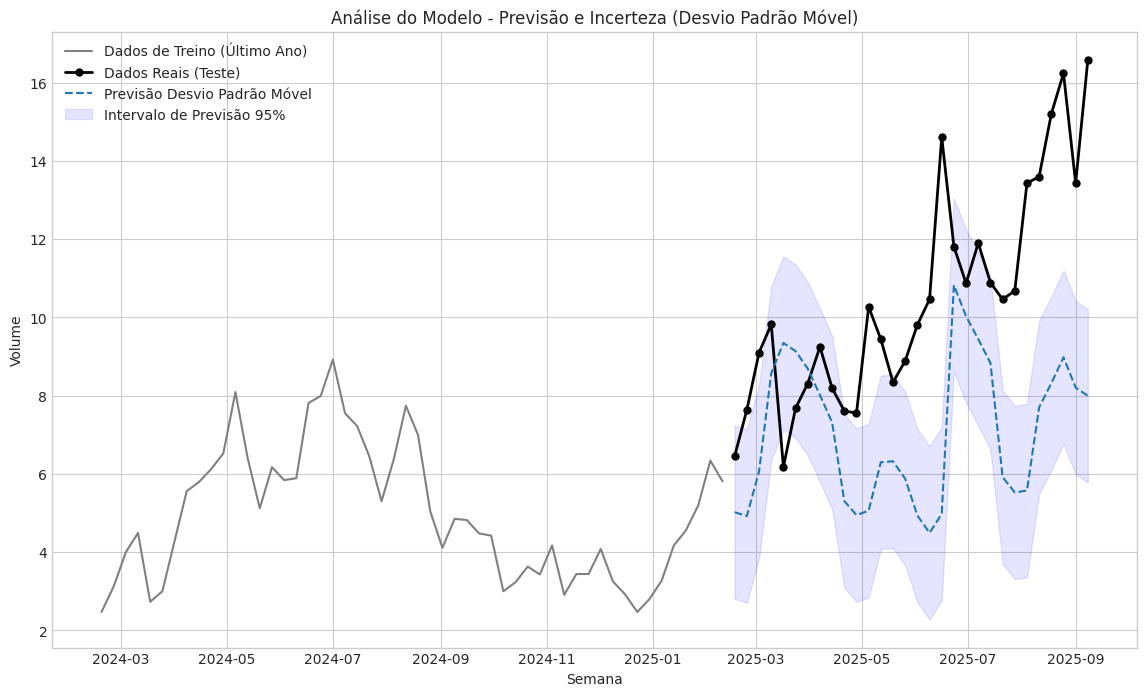

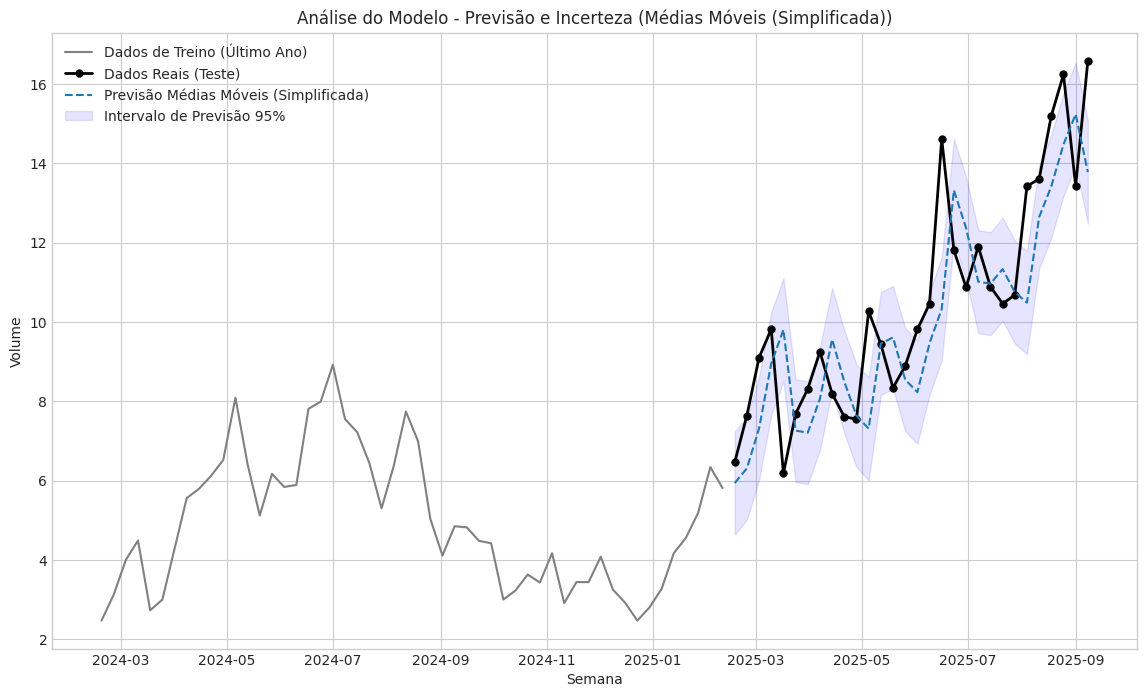

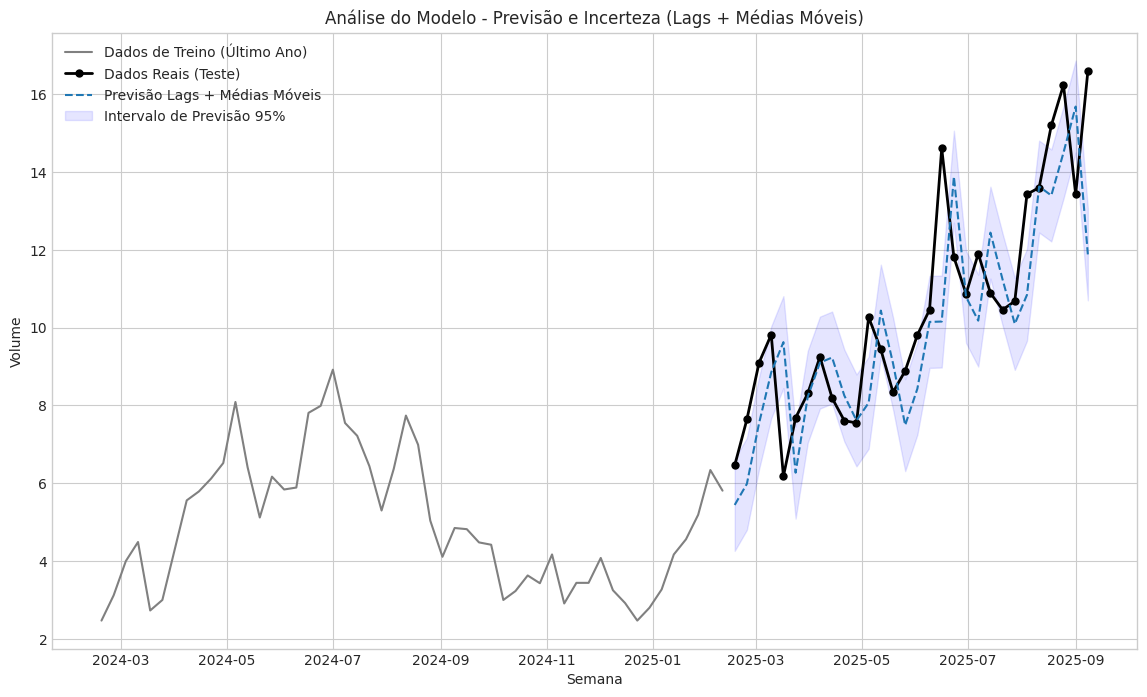

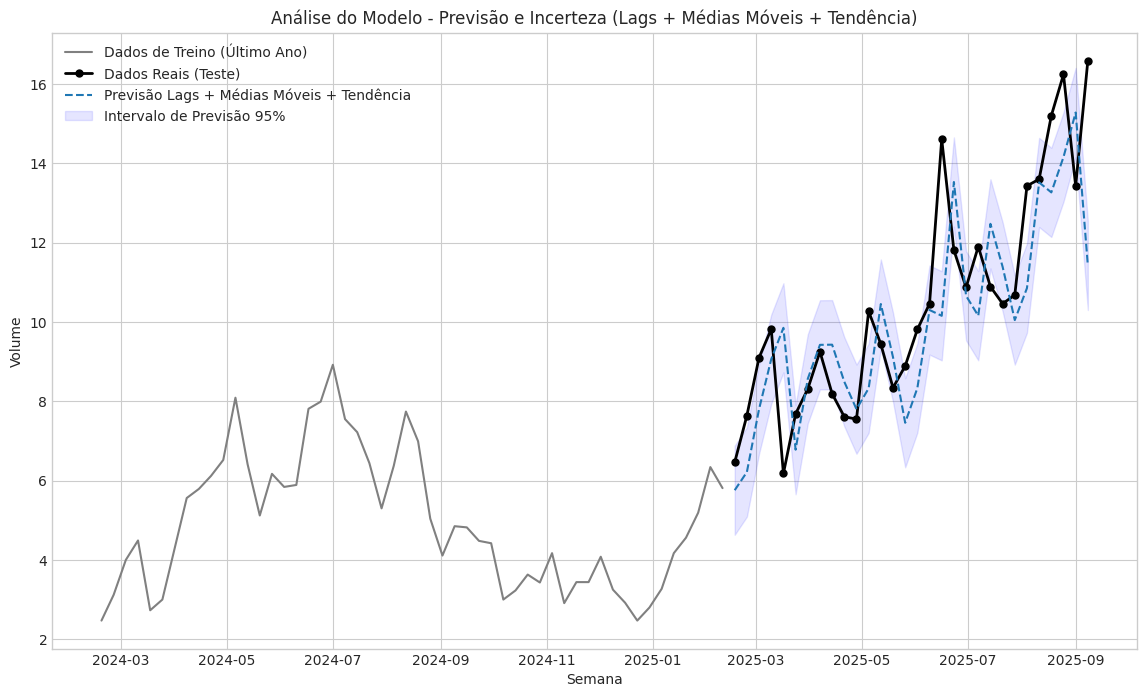

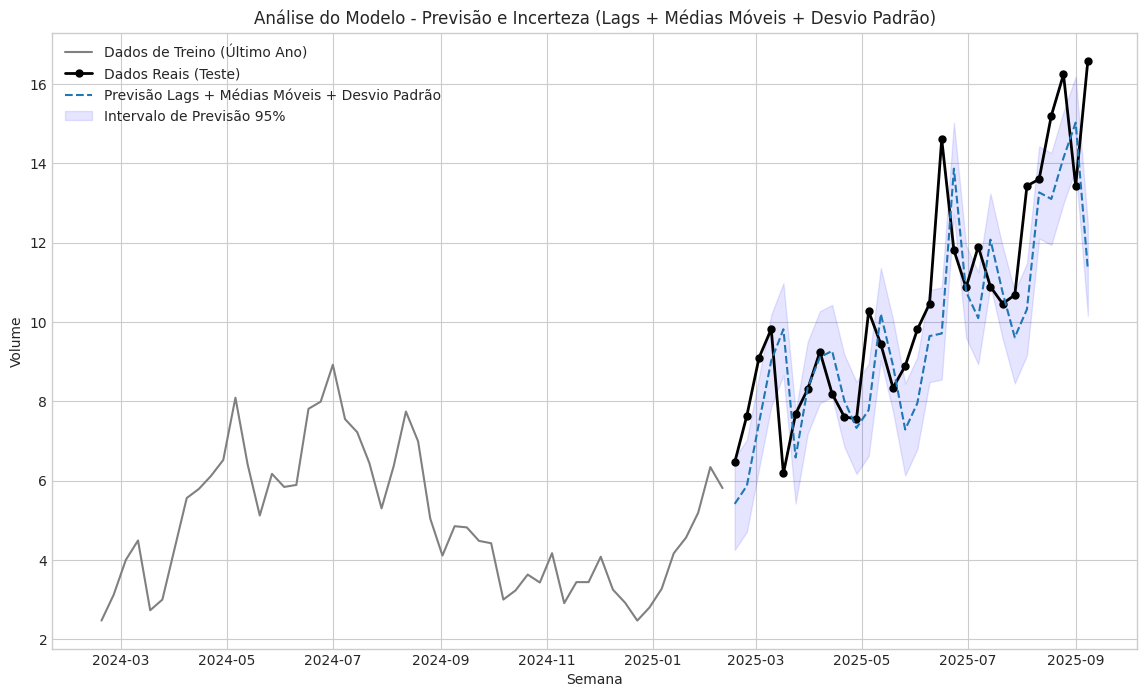

In [13]:
model_names = models.keys()

for name in model_names:
    plt.figure(figsize=(14, 8))

    plt.plot(
        y_train.iloc[-52:], label='Dados de Treino (Último Ano)', color='gray'
    )
    plt.plot(
        y_test,
        label='Dados Reais (Teste)',
        color='black',
        linewidth=2,
        marker='o',
        markersize=5,
    )

    forecast_to_plot = predictions[name]
    interval_to_plot = intervals[name]

    plt.plot(forecast_to_plot, label=f'Previsão {name}', linestyle='--')

    plt.fill_between(
        interval_to_plot['lower'].index,
        interval_to_plot['lower'],
        interval_to_plot['upper'],
        color='blue',
        alpha=0.1,
        label='Intervalo de Previsão 95%',
    )

    plt.title(f'Análise do Modelo - Previsão e Incerteza ({name})')
    plt.xlabel('Semana')
    plt.ylabel('Volume')
    plt.legend(loc='upper left')
    plt.grid(True)

    plt.show()

Por fim, visualizamos os resultados dos modelos, que apresentaram um desempenho muito bom. Além disso, os modelos de médias móveis e lags conseguiram capturar a maioria dos padrões da série temporal.